In [2]:
import tensorflow as tf
from tensorflow import keras
import os,sys
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from keras.models import *
#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [1]:
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

In [5]:
base_path = r'D:/Dateset_projekt_grupa/archive/'
train_set_dir = base_path + 'train'
val_set_dir = base_path + 'val'
test_set_dir = base_path + 'test'

In [ ]:
image_size=(224,224)
batch_size = 32

In [7]:
#listdir listue nam nazwy plików w określonej ścieżce
print('\ntrain:')
for name in os.listdir(base_path + 'train'):
    print(str(len(os.listdir(base_path + 'train/' + name))) + " " + name + " images")
    
print('\nval:')
for name in os.listdir(base_path + 'val'):
    print(str(len(os.listdir(base_path + 'val/' + name))) + " " + name + " images")

print('\ntest:')
for name in os.listdir(base_path + 'test'):
    print(str(len(os.listdir(base_path + 'test/' + name))) + " " + name + " images")


train:
460 COVID19 images
1341 NORMAL images
3875 PNEUMONIA images
650 TURBERCULOSIS images

val:
21 COVID19 images
83 NORMAL images
38 PNEUMONIA images
22 TURBERCULOSIS images

test:
95 COVID19 images
159 NORMAL images
360 PNEUMONIA images
31 TURBERCULOSIS images


In [8]:
labels = []
for name in os.listdir(base_path + 'train'):
    labels.append(name)
print(f'Nasze labele to: {labels}')


Nasze labele to: ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']


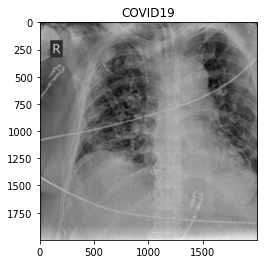

[[ 83  84  86 ... 133 130 134]
 [ 88  85  83 ... 131 130 133]
 [ 86  86  85 ... 126 125 127]
 ...
 [204 201 202 ... 223 226 222]
 [209 204 203 ... 221 224 222]
 [205 201 204 ... 220 222 222]]


In [9]:
import matplotlib.pyplot as plt
import random
from pathlib import Path
import numpy as np
import cv2

for label in labels: #iterujemy po labelach
    #path = os.path.join(base_path + 'train/' + label) 
    path = base_path + 'train/' + label #tworzymy ścieżkę do pliku ze zdjęciami
    for img in os.listdir(path): #gdy jesteśmy już w pliku ze zdjęciami, iterujemy po jego zawartości
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE) # zaczytanie zdjęcia w grayscale
        plt.imshow(img_array, cmap = 'gray')
        plt.title(label)
        plt.show()
        break #gdyby nie było w tych miejscach break zaczęlibyśmy iterować po całej zawartości
    break
    
print(img_array)


In [10]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1/255,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  rotation_range=5)
test_datagen = ImageDataGenerator(rescale = 1/255)

In [11]:
train_generator = train_datagen.flow_from_directory(train_set_dir,
                                                     target_size = image_size,
                                                      color_mode='rgb',
                                                      class_mode='categorical',
                                                      batch_size=batch_size)
val_generator = test_datagen.flow_from_directory(val_set_dir,
                                                     target_size = image_size,
                                                      color_mode='rgb',
                                                      class_mode='categorical',
                                                      batch_size=batch_size)
test_generator = test_datagen.flow_from_directory(test_set_dir,
                                                     target_size = image_size,
                                                      color_mode='rgb',
                                                      class_mode='categorical',
                                                      batch_size=batch_size)


Found 6326 images belonging to 4 classes.
Found 164 images belonging to 4 classes.
Found 645 images belonging to 4 classes.


In [12]:
from keras.applications import DenseNet121

base_model = DenseNet121(
    include_top=False,
    weights="imagenet",
    input_tensor=Input(shape=(image_size+(3,)))
)

In [14]:
#creating head
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(512, activation='relu')(x)
x=Dropout(0.25)(x)
prediction=Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs = prediction)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000, 1000,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 1006, 1006,   0          ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, 500, 500, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                             

In [15]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics = ["accuracy"])              

In [16]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=1,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True)


In [17]:
train_steps = train_generator.samples//batch_size
val_steps = val_generator.samples//batch_size
test_steps = test_generator.samples//batch_size

In [ ]:
hist = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs = 100,

    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=[callback]
)

Epoch 1/100


In [ ]:
model.evaluate(data.test_generator, steps=test_steps)